# YouTube Live Capture
> This module is used to capture images from YouTube live.

In [ ]:
#| default_exp vision.ytlive

In [ ]:
#|hide
from nbdev.showdoc import *

In [ ]:
#|export
from datetime import datetime
from IPython.display import Image, display
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
import cv2
import glob
import matplotlib.pyplot as plt
import os
import pytesseract
import time
import yt_dlp as youtube_dl

# Näkymä Helsingistä location list

In [ ]:
#|export
nakyma_helsinki_known_places = [
    "Olympiaterminaali",
    "Etelasatama",
    #"Eteläsatama",  # fixup
    "Eteladsatama", # fixup
    "Presidentinlinna",
    "Tuomiokirkko",
    "Kauppatori",
    "Kauppator",    # fixup   
    "Torni",
    "Valkosaari",
]

# YouTube Capture Experiment

In [ ]:
#|export
nakyma_helsinkigista_youtube_live_url = "https://www.youtube.com/watch?v=LMZQ7eFhm58"
ydl_opts = {
    'cookiefile': "cookies.txt",  # Path to the exported cookies file,  # Use cookies for authentication
    'download': False  # Set to True if you want to download
}

In [ ]:
#|eval: false
with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info = ydl.extract_info(nakyma_helsinkigista_youtube_live_url, download=False)
    for o in info['formats']:
        if o['resolution'] == '1280x720':
            print(o['url'])
            break
    else:
        raise ValueError("No 1280x720 format")

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading mweb player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
[youtube] LMZQ7eFhm58: Downloading m3u8 information
https://manifest.googlevideo.com/api/manifest/hls_playlist/expire/1733790768/ei/0DdXZ8m1L4OJ0u8PxoGNiAg/ip/82.130.25.234/id/LMZQ7eFhm58.4/itag/232/source/yt_live_broadcast/requiressl/yes/ratebypass/yes/live/1/sgovp/gir%3Dyes%3Bitag%3D136/rqh/1/hdlc/1/hls_chunk_host/rr2---sn-ovgq0oxu-5goe.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/3600/manifest_duration/3600/spc/qtApAQyt1KIEXVkEetoxa9_Y-fSoSEMtncu6A3nv3LkAqKv5pQ/vprv/1/playlist_type/DVR/initcwndbps/1963750/met/1733769169,/mh/l8/mm/44/mn/sn-ovgq0oxu-5goe/ms/lva/mv/m/mvi/2/pl/21/rms/lva,lva/dover/13/pacing/0/short_key/1/keepalive/yes/fexp/51326932,51335594,51347746/mt/1733768684/sparams/expire,ei,ip,id,it

In [ ]:
#|export
def stream_url(ytlive_url:str, ydl_opts:dict) -> str:
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(ytlive_url, download=False)
        for o in info['formats']:
            if o['resolution'] == '1280x720':
                return o['url']
        else:
            raise ValueError("No 1280x720 format")    

In [ ]:
#|export
def show_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB for Matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    plt.show()   

In [ ]:
#|export
def crop_frame(frame, crop=(0, 0, 480, 30)):
    x, y, w, h = crop
    return frame[y:y+h, x:x+w]    

In [ ]:
#|export
def frame_to_text(frame): return pytesseract.image_to_string(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).strip()

In [ ]:
#|export
def known(txt:str, known_places:str) -> str:
    "try to find one of `known_places` are included in the given `txt`"
    for o in known_places:
        #print(o, "in", txt)
        if o in txt:
            return o
    raise Exception("No place specified")

In [ ]:
assert known("Torninnnnnn", nakyma_helsinki_known_places)=="Torni"

In [ ]:
#|export
def meta(frame, known_places=nakyma_helsinki_known_places, printing=False):
    "Withdraw meta data, datetime & place"
    # "04.10.2024  14:53:49  Kauppatori", Original format
    txt = frame_to_text(frame)
    if printing==True: print(txt)
    dt = datetime.strptime(txt[:19],"%d.%m.%Y %H:%M:%S")
    pl = known(txt[20:], known_places)
    pl = pl.replace("Eteladsatama", "Etelasatama") # fixup
    pl = pl.replace("ä", "a")                      # fixup
    pl = pl.replace("kauppator", "kauppatori")     # fixup
    return dt, pl

In [ ]:
#|export
def fname(prefix, dt, pl): return f"""{prefix}{dt.strftime("%Y.%m.%d_%H:%M:%S")}_{pl}.jpg"""

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading mweb player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
[youtube] LMZQ7eFhm58: Downloading m3u8 information


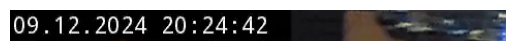

09.12.2024 20:24:42
09.12.2024 20:24:42
No place specified


In [ ]:
#| eval: false
url = stream_url(nakyma_helsinkigista_youtube_live_url, ydl_opts)
cap = cv2.VideoCapture(url)
ret, frame = cap.read()
if ret:
    show_frame(crop_frame(frame))
    print(frame_to_text(crop_frame(frame)))
    try:
        print(fname("cap_", *meta(crop_frame(frame), printing=True)))
    except Exception as e:
        print(e)
else:
    print("Failed to capture frame.")

In [ ]:
#|eval: false
def capture_youtube_live_frame(youtube_live_url:str=nakyma_helsinkigista_youtube_live_url):
    "Capture a frame from the given YouTube Live URL and save into a JPEG file"

    url = stream_url(youtube_live_url, ydl_opts)
    cap = cv2.VideoCapture(url)
    ret, frame = cap.read()
    #show_frame(crop_frame(frame))
    if ret==False:
        raise Exception("Failed to capture frame.")
    try:        
        path = Path(os.getenv("LLMCAM_DATA", "../data"))/fname("cap_", *meta(crop_frame(frame), printing=True))
    except:
        path = Path(os.getenv("LLMCAM_DATA", "../data"))/fname("fail_", datetime.now(), "nowhere")
    path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(path, frame)
    return path

file = capture_youtube_live_frame()
file

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading mweb player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
[youtube] LMZQ7eFhm58: Downloading m3u8 information
09.12.2024 20:24:42


Path('/home/nghivo/tinyMLaaS/llmcam/data/fail_2024.12.09_20:33:04_nowhere.jpg')

In [ ]:
#| export
class YTLive:
    def __init__(self,
                 url:str, # YouTube Live URL
                 data_dir:Path = Path(os.getenv("LLMCAM_DATA", "../data")), # directory to store captured images
                 place:str="nowhere", # place name
                ):
        self.url = url
        self.stream_url = stream_url(url, ydl_opts)
        self.data_dir = data_dir
        self.place = place

    def file_name(self, frame=None):
        return fname("cap_", datetime.now(), self.place)

    def capture(self) -> Path:
        cap = cv2.VideoCapture(self.stream_url)
        ret, frame = cap.read()
        if ret==False:
            raise Exception("Failed to capture frame.")
        fn = self.data_dir/self.file_name(frame)
        cv2.imwrite(fn, frame)
        return fn     

    def __call__(self):
        # __call__ method allows the instance to be called like a function
        return self.capture()

In [ ]:
show_doc(YTLive)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/ytlive.py#L95){target="_blank" style="float:right; font-size:smaller"}

### YTLive

>      YTLive (url:str,
>              data_dir:pathlib.Path=Path('/home/nghivo/tinyMLaaS/llmcam/data'),
>              place:str='nowhere')

*Initialize self.  See help(type(self)) for accurate signature.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| url | str |  | YouTube Live URL |
| data_dir | Path | /home/nghivo/tinyMLaaS/llmcam/data | directory to store captured images |
| place | str | nowhere | place name |

In [ ]:
#| eval: false
SantaClausVilledge = YTLive(url="https://www.youtube.com/live/Cp4RRAEgpeU?si=IwqJ4QU1Umv9PdgW", place="santaclausvillege")
file = SantaClausVilledge()
file

[youtube] Extracting URL: https://www.youtube.com/live/Cp4RRAEgpeU?si=IwqJ4QU1Umv9PdgW
[youtube] Cp4RRAEgpeU: Downloading webpage
[youtube] Cp4RRAEgpeU: Downloading ios player API JSON
[youtube] Cp4RRAEgpeU: Downloading mweb player API JSON
[youtube] Cp4RRAEgpeU: Downloading m3u8 information
[youtube] Cp4RRAEgpeU: Downloading m3u8 information


Path('/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:33:06_santaclausvillege.jpg')

In [ ]:
#| export
class NHsta(YTLive):
    def __init__(self,
                 url:str="https://www.youtube.com/watch?v=LMZQ7eFhm58", # YouTube Live URL
                 data_dir:Path = Path(os.getenv("LLMCAM_DATA", "../data")), # directory to store captured images
                 place:str="unclear", # place name if OCR doesn't work
                ):
        super().__init__(url, data_dir, place)
    
    def file_name(self, frame):
        try:        
            path = fname("cap_", *meta(crop_frame(frame), printing=True))
        except Exception as e:
            path = super().file_name()
            print(path)
        return path

In [ ]:
show_doc(NHsta)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/ytlive.py#L123){target="_blank" style="float:right; font-size:smaller"}

### NHsta

>      NHsta (url:str='https://www.youtube.com/watch?v=LMZQ7eFhm58',
>             data_dir:pathlib.Path=Path('/home/nghivo/tinyMLaaS/llmcam/data'),
>             place:str='unclear')

*Initialize self.  See help(type(self)) for accurate signature.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| url | str | https://www.youtube.com/watch?v=LMZQ7eFhm58 | YouTube Live URL |
| data_dir | Path | /home/nghivo/tinyMLaaS/llmcam/data | directory to store captured images |
| place | str | unclear | place name if OCR doesn't work |

In [ ]:
#| eval: false
NakymaHelsingista = NHsta()
file = NakymaHelsingista()
file

[youtube] Extracting URL: https://www.youtube.com/watch?v=LMZQ7eFhm58
[youtube] LMZQ7eFhm58: Downloading webpage
[youtube] LMZQ7eFhm58: Downloading ios player API JSON
[youtube] LMZQ7eFhm58: Downloading mweb player API JSON
[youtube] LMZQ7eFhm58: Downloading m3u8 information
[youtube] LMZQ7eFhm58: Downloading m3u8 information
09.12.2024 20:24:47 Presidentinlinna


Path('/home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:24:47_Presidentinlinna.jpg')

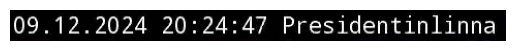

In [ ]:
#|eval: false
def crop_image(path, crop=(0, 0, 480, 30)): return Image.open(path).crop(crop)
def show_image(path):
    plt.imshow(crop_image(path))
    plt.axis('off')
    plt.show()

show_image(file)

# Extract meta data from an image file

In [ ]:
#|eval: false
try:
    fname("cap_", *meta(files[1]))
except:
    pass

## Rename files with meta info

"cap_2024.10.04_14:56:49_Presidentinlinna"

"cap_2024.10.06_19:04:14_Kauppatori"

"cap_2024.10.06_20:08:29_Kauppatori"

In [ ]:
#|eval: false
for i, o in enumerate(glob.glob("../data/cap_*_unclear.jpg")):
    try:
        new = Path("../data")/fname("cap_", *meta(o, True))
        print(i, o, " -> ", new)
        os.rename(o, new)
    except Exception as e:
        print(o)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()